Sumber Data : https://www.kaggle.com/hgultekin/bbcnewsarchive?select=bbc-news-data.csv

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6826875910000183
GPU (s):
0.04767378099998609
GPU speedup over CPU: 77x


In [6]:
import pandas as pd
import os, re, string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')
df = df.drop(columns=['filename'])

In [8]:
df.head()

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [9]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [10]:
df.shape

(2225, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


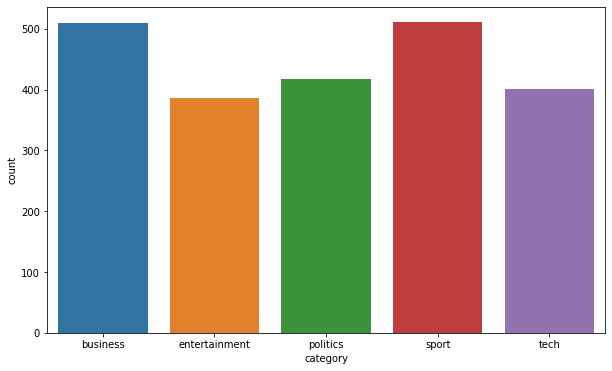

In [11]:
plt.figure(figsize = (10, 6))
sns.countplot(df.category)

In [12]:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)

In [13]:
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df.title = df.title.apply(lambda x: cleaner(x))
    df.content = df.content.apply(lambda x: lem(x))

def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df['title'].apply(rem_numbers)
    df['content'].apply(rem_numbers)

In [14]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df.title = df.title.apply(lambda x: lem(x))
    df.content = df.content.apply(lambda x: lem(x))

In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stwrds = stopwords.words('english')
def stopword(data):
    return(' '.join([w for w in data.split() if w not in stwrds ]))
    df.title = df.title.apply(lambda x: stopword(x))
    df.content = df.content.apply(lambda x: lem(x))

In [17]:
category = pd.get_dummies(df['category'])
df = pd.concat([df, category], axis=1)
df = df.drop('category', axis=1)
df.head()

,title,content,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0


In [18]:
a = df['title'].values + '' + df['content'].values

In [19]:
a

array(['Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

In [20]:
b=df.iloc[:,2:]

In [21]:
b

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2220,0,0,0,0,1
2221,0,0,0,0,1
2222,0,0,0,0,1
2223,0,0,0,0,1


In [22]:
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.2, random_state=42)

In [23]:
print(b_train.shape)
print(b_test.shape)

(1780, 5)
(445, 5)


In [24]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')

tokenizer.fit_on_texts(a_train) 
tokenizer.fit_on_texts(a_test)
 
sekuens_train = tokenizer.texts_to_sequences(a_train)
sekuens_test = tokenizer.texts_to_sequences(a_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.90):
      self.model.stop_training = True
      print("\nAkurasi sudah mencapai > 97%, hentikan proses training!")
callbacks = myCallback()

In [28]:
model = tf.keras.Sequential([
     tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LSTM(64),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(5, activation='softmax')
     ])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'
              ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 357,765
Trainable params: 357,637
Non-trainable params: 128
______________________________________________

In [29]:
history = model.fit(padded_train, b_train, epochs=50, 
                    validation_data=(padded_test, b_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
56/56 - 26s - loss: 1.5969 - accuracy: 0.2691 - val_loss: 1.6028 - val_accuracy: 0.2449
Epoch 2/50
56/56 - 24s - loss: 1.2464 - accuracy: 0.5191 - val_loss: 1.5537 - val_accuracy: 0.4674
Epoch 3/50
56/56 - 23s - loss: 0.6482 - accuracy: 0.7966 - val_loss: 1.3464 - val_accuracy: 0.6090
Epoch 4/50
56/56 - 24s - loss: 0.2527 - accuracy: 0.9320 - val_loss: 1.0886 - val_accuracy: 0.6427
Epoch 5/50
56/56 - 24s - loss: 0.1189 - accuracy: 0.9685 - val_loss: 0.9220 - val_accuracy: 0.7079
Epoch 6/50
56/56 - 23s - loss: 0.0542 - accuracy: 0.9899 - val_loss: 0.8237 - val_accuracy: 0.7303
Epoch 7/50
56/56 - 24s - loss: 0.0179 - accuracy: 0.9978 - val_loss: 0.7433 - val_accuracy: 0.7753
Epoch 8/50
56/56 - 24s - loss: 0.0157 - accuracy: 0.9972 - val_loss: 0.4448 - val_accuracy: 0.8787
Epoch 9/50
56/56 - 23s - loss: 0.0194 - accuracy: 0.9978 - val_loss: 0.6527 - val_accuracy: 0.8517
Epoch 10/50
56/56 - 24s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.6823 - val_accuracy: 0.8607
Epoch 11/

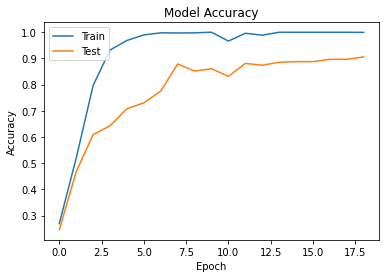

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

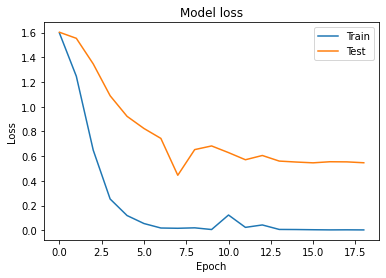

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()